## XOR LSTM

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

- Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

- Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Notes:
    
- The RNN seems to work only with small sequence sizes. Less than 6
- Even if I increase the number of epochs or change the lr, it does not fit

- Sometimes, I run the same experiemnt, with the same seq length and the model alternates between fitting and not fitting

In [2]:
# data = np.random.binomial(1, 0.5, (100000, 50, 1))
# data.shape

## Generating the dataset

In [3]:
number_of_sequences = 100000
sequence_length = 16

In [4]:
np.random.seed(888)
dataset = np.random.choice(2, [number_of_sequences, sequence_length])

For sequences of more than 2 bits, the XOR function should output TRUE when the number of TRUE values is odd (in the sequence)

In [5]:
sequence_labels = []
for sequence in dataset:
    label = np.count_nonzero(sequence)
    if label % 2 == 0: # even
        sequence_labels.append(0)
    else: # odd
        # For sequences of more than 2 bits, the XOR function should output TRUE when
        # the number of TRUE values is odd (in the sequence)
        sequence_labels.append(1)
sequence_labels = np.asarray(sequence_labels)

In [6]:
print("Input shape:", dataset.shape)
print("Labals shape:", sequence_labels.shape)

Input shape: (100000, 16)
Labals shape: (100000,)


In [7]:
count = 0
for inputs, target in zip(dataset, sequence_labels):
    print(inputs, target)
    count += 1
    if count == 5:
        break
      
# [0 0 1 1 0] 0
# [1 1 0 1 0] 1
# [1 1 0 1 0] 1
# [0 1 1 0 0] 0
# [0 1 0 0 0] 1

[0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0] 0
[1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0] 0
[0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0] 1
[1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1] 0
[0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0] 1


In [8]:
counter = Counter(sequence_labels)

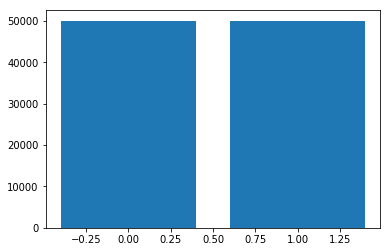

In [9]:
plt.bar([0,1], [counter[0], counter[1]])
plt.show()

In [10]:
import tensorflow as tf

In [11]:
def RNN(inputs, seq_length, num_layers=3):
    # reshape to [1, n_input]
    inputs = tf.reshape(inputs, [-1, seq_length])
    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    inputs = tf.split(inputs,seq_length,1)
    print(inputs)
    rnn = tf.contrib.rnn.BasicLSTMCell(num_units=256)
    
#     def lstm_cell():
#         cell = tf.contrib.rnn.LSTMCell(num_units=128)
#         return cell
    
#     # Construct a stacked tf.contrib.rnn.LSTMCell wrapped in a tf.contrib.rnn.DropoutWrapper
#     rnn = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_layers)])
    
    # unroll the rnn
    output, state = tf.nn.static_rnn(rnn,
                                     inputs,
                                     initial_state=None,
                                     dtype=tf.float32)
    print(output[-1])
    out = tf.layers.flatten(output[-1])
    print(out)
    logits = tf.layers.dense(out, 2, activation=None)
    
    return logits

In [12]:
def reshape_input(x, y):
    print(x.shape)
    return tf.expand_dims(x, axis=1), y

In [13]:
from sklearn.model_selection import train_test_split

dataset = dataset.astype(np.float32)
sequence_labels = sequence_labels.astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(dataset, sequence_labels, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_test.shape)

(90000, 16)
(10000, 16)


In [14]:
X_train

array([[1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [15]:
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_dataset = training_dataset.map(lambda x, y: reshape_input(x,y))
training_dataset = training_dataset.shuffle(1000)
training_dataset = training_dataset.repeat(6)
training_dataset = training_dataset.batch(64)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_dataset = validation_dataset.map(lambda x, y: reshape_input(x,y))
validation_dataset = validation_dataset.repeat(1)
validation_dataset = validation_dataset.batch(128)

# A feedable iterator is defined by a handle placeholder and its structure. We
# could use the `output_types` and `output_shapes` properties of either
# `training_dataset` or `validation_dataset` here, because they have
# identical structure.
handle = tf.placeholder(tf.string, shape=[])

iterator = tf.data.Iterator.from_string_handle(
    handle, training_dataset.output_types, training_dataset.output_shapes)
batch_samples, batch_labels = iterator.get_next()

# You can use feedable iterators with a variety of different kinds of iterator
# (such as one-shot and initializable iterators).
training_iterator = training_dataset.make_initializable_iterator()
validation_iterator = validation_dataset.make_one_shot_iterator()

(16,)
(16,)


In [16]:
logits = RNN([batch_samples], sequence_length)
#logits = DNN(batch_samples)
    
predictions = tf.argmax(logits, axis=1)

print(predictions)
print(batch_labels)
# accuracy
correct_predictions = tf.equal(predictions, tf.cast(batch_labels, tf.int64))
accuracy_op = tf.reduce_mean(tf.to_float(correct_predictions))

log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(batch_labels, 2), logits=logits)
cost = tf.reduce_mean(log_loss)

[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:10' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:11' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:12' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:13' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:14' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:15' shape=(?, 1) dtype=float32>]
Tensor("rnn/basic_lstm_cell/Mul_47:0", shape=(?, 256), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 256), dtype=float32)
Tensor("ArgMax:0", shape=(?,), dtype=int64)
Tensor("IteratorGetN

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

model_vars = tf.trainable_variables()
gradients = tf.gradients(cost, model_vars)
#gradients, _ = tf.clip_by_global_norm(gradients, 5.) # gradient clipping

minimize = optimizer.apply_gradients(zip(gradients, model_vars))

In [18]:
training_loss = []
training_acc = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(training_iterator.initializer)
    
    # The `Iterator.string_handle()` method returns a tensor that can be evaluated
    # and used to feed the `handle` placeholder.
    training_handle = sess.run(training_iterator.string_handle())
    validation_handle = sess.run(validation_iterator.string_handle())
    
    counter = 0
    while True:
        counter += 1
        try:
            _, acc, train_loss = sess.run([minimize, accuracy_op, cost], feed_dict={handle: training_handle})
            training_loss.append(train_loss)    
            training_acc.append(acc)
        except tf.errors.OutOfRangeError:
            print("Done training at step:", counter)
            break
        
    validation_acc = []
    validation_loss = []
    while True:
        try:
            val_acc, val_loss = sess.run([accuracy_op, cost], feed_dict={handle: validation_handle})
            validation_loss.append(val_loss)
            validation_acc.append(val_acc)
        except tf.errors.OutOfRangeError:
            print("Done testing")
            break

InternalError: Blas GEMM launch failed : a.shape=(64, 257), b.shape=(257, 1024), m=64, n=1024, k=257
	 [[Node: rnn/basic_lstm_cell/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](rnn/basic_lstm_cell/concat, rnn/basic_lstm_cell/kernel/read)]]
	 [[Node: Mean/_11 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1940_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'rnn/basic_lstm_cell/MatMul', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-7edded561cfa>", line 1, in <module>
    logits = RNN([batch_samples], sequence_length)
  File "<ipython-input-11-218ea1030c3b>", line 21, in RNN
    dtype=tf.float32)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 1324, in static_rnn
    (output, state) = call_cell()
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 1311, in <lambda>
    call_cell = lambda: cell(input_, state)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 339, in __call__
    *args, **kwargs)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 717, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 620, in call
    array_ops.concat([inputs, h], 1), self._kernel)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2122, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4279, in mat_mul
    name=name)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/thalles/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(64, 257), b.shape=(257, 1024), m=64, n=1024, k=257
	 [[Node: rnn/basic_lstm_cell/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](rnn/basic_lstm_cell/concat, rnn/basic_lstm_cell/kernel/read)]]
	 [[Node: Mean/_11 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1940_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
plt.plot(training_loss)
#plt.plot(validation_loss)

In [ ]:
print("Train Mean acc:", np.mean(training_acc))
print("Test Mean acc:", np.mean(validation_acc))

plt.plot(training_acc)
#plt.plot(validation_acc)